# Geo-Distribution of Tourism #

The tourism industry has been masively affected by the Covid-19 situation. One of the indicators for travelling is the number of Airbnb reviews, treated here as demand.

This notebook extracts the data from InsideAirbnb, aggregates it and displays the number of reviews for each neighbourhood per month.

### Inputs: ###
<br>Bristol_reviews.csv - This dataset is the reviews file downloaded from http://insideairbnb.com/get-the-data.html. It contains all the reviews up to the last scraped date. <br/>
<br> Bristol_listings.csv - This dataset is the listings file downloaded from http://insideairbnb.com/get-the-data.html. It contains the listings of that specific month. <br/>
<br>neighbourhoods.geojson - This dataset is the geojson file downloaded from http://insideairbnb.com/get-the-data.html. It contains the geometry of the neighbourhoods.


### Steps ###
<br>Get the number of reviews per day per city.
<br>Get the number of reviews per day per district.
<br>Normalize teh number of reviews for each month.
<br>Plot each neighbourhood for a given month.

In [3]:
!pip install shapely
!pip install geopandas
!pip install geojsonio
!pip install descartes
!pip install wget

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import io
import wget
from os.path import isfile
from os import remove

In [4]:
r = requests.get("http://insideairbnb.com/get-the-data.html")
soup = BeautifulSoup(r.text)
alldata = {}

for table in tqdm(soup.findAll("table",{"class":"table-hover"})):
    #print(str(table)[:100])
    df = pd.read_html(io.StringIO(str(table)))[0]
    df["downloadlink"] = ""
    index = 0
    for link in table.findAll("a",href=True):
        #print(link["href"])
        df.at[index,"downloadlink"] = link["href"]
        index += 1
    city = df["Country/City"].unique()[0]
    alldata[city] = df

100%|██████████| 103/103 [00:04<00:00, 21.25it/s]


## Get reviews per day per city

In [5]:
def get_reviews_for_city(city_name):
    city_name = city_name.replace(" ", "_")
    filename = f"{city_name}_reviews.csv"
    if not isfile(filename):
        return None
    df = pd.read_csv(filename)    

    df["number_of_reviews"] = 1
    df = df[["date", "number_of_reviews"]]\
            .groupby("date")\
            .sum()\
            .reset_index(drop=False)\
            .rename(columns={
                "number_of_reviews": city_name}
            )
    df = df[df["date"] != "0"]
    df.date = pd.to_datetime(df.date)
    df.set_index("date", drop=True, inplace=True)
    df = df.astype(float)
    df = df.resample('D').mean()
    t_index = pd.DatetimeIndex(start='2014-01-01', end='2020-06-30', freq='D')
    df = df.interpolate(method='linear', limit_area="inside")
    return df

In [6]:
city_names = list(alldata.keys())
df_final = pd.DataFrame()
for idx, city_name in enumerate(city_names):
    print("City: ", city_name)
    if idx > 1000000:
        break
    df = get_reviews_for_city(city_name)
    if df is not None:
        df_final = pd.concat([df_final, df], axis=1)

City:  Amsterdam
City:  Antwerp
City:  Asheville
City:  Athens
City:  Austin
City:  Barcelona
City:  Barossa Valley
City:  Barwon South West, Vic
City:  Beijing
City:  Belize
City:  Bergamo
City:  Berlin
City:  Bologna
City:  Bordeaux
City:  Boston
City:  Bristol


/Users/mariaivanciu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


City:  Broward County
City:  Brussels
City:  Buenos Aires
City:  Cambridge
City:  Cape Town
City:  Chicago
City:  Clark County, NV
City:  Columbus
City:  Copenhagen
City:  Crete
City:  Denver
City:  Dublin
City:  Edinburgh
City:  Euskadi
City:  Florence
City:  Geneva
City:  Ghent
City:  Girona
City:  Greater Manchester
City:  Hawaii
City:  Hong Kong
City:  Ireland
City:  Istanbul
City:  Jersey City
City:  Lisbon
City:  London
City:  Los Angeles
City:  Lyon
City:  Madrid
City:  Malaga
City:  Mallorca
City:  Manchester
City:  Melbourne
City:  Menorca
City:  Mexico City
City:  Milan
City:  Montreal
City:  Munich
City:  Naples
City:  Nashville
City:  New Brunswick
City:  New Orleans
City:  New York City
City:  Northern Rivers
City:  Oakland
City:  Oslo
City:  Ottawa
City:  Pacific Grove
City:  Paris
City:  Portland
City:  Porto
City:  Prague
City:  Puglia
City:  Quebec City
City:  Rhode Island
City:  Rio de Janeiro
City:  Rome
City:  Salem, OR
City:  San Diego
City:  San Francisco
City:  S

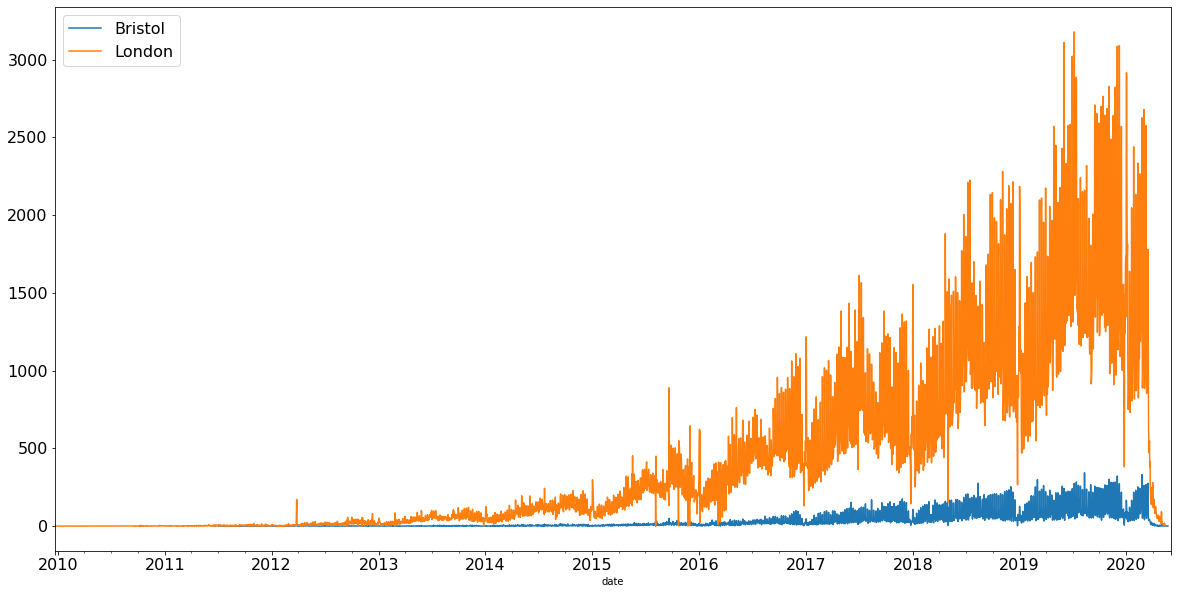

In [12]:
fig = df_final[["Bristol", "London"]].plot(figsize=(20, 10),fontsize= 16)
fig.legend(fontsize =16)

## Get reviews per day per district

In [13]:
def get_geojson_url(city_name):
    df_city_info = alldata[city_name]
    df_city_info = df_city_info[df_city_info["File Name"] == "neighbourhoods.geojson"]
    return df_city_info["downloadlink"].iloc[0]

def download_geojson(geojson_url):
    if isfile("neighbourhoods.geojson"):
        remove("neighbourhoods.geojson")
    wget.download(geojson_url)

In [18]:
def get_reviews_by_district(city_name):
    
    geojson_url = get_geojson_url(city_name)
    download_geojson(geojson_url)
    if not isfile('neighbourhoods.geojson'):
        return None
    df_places = gpd.read_file('neighbourhoods.geojson')
    df_places["neighbourhood"] = df_places["neighbourhood"].astype(str)
    
    city_name = city_name.replace(" ", "_")
    filename = f"{city_name}_listings.csv"
    if not isfile(filename):
        return None
    df = pd.read_csv(filename)
    df = df[["id", "neighbourhood_cleansed"]]
    df.drop_duplicates(subset=["id"], keep="first", inplace=True)
    df["neighbourhood_cleansed"] = df["neighbourhood_cleansed"].astype(str)

    df = pd.merge(df, df_places, left_on="neighbourhood_cleansed", right_on="neighbourhood", how="left")
    df.fillna(0, inplace=True)
    df = df[["id", "neighbourhood", "geometry"]]
    
    filename = f"{city_name}_reviews.csv"
    if not isfile(filename):
        return None
    df_reviews = pd.read_csv(filename) 
    df = pd.merge(df, df_reviews, left_on="id", right_on="listing_id", how="right")
    df["yearmonth"] = df["date"].apply(lambda x: str(x)[:7])
    print(df)
    df.drop(["listing_id", "date"], axis=1, inplace=True)

    df["n_reviews"] = 1
    df = df.groupby(["neighbourhood", "yearmonth"]).agg({
            "geometry": lambda x: x.iloc[0],
            "n_reviews": sum
        }).reset_index(drop=False)

    return df


In [19]:
df = get_reviews_by_district("Bristol")

            id_x            neighbourhood  \
0         117122                  Clifton   
1         117122                  Clifton   
2         117122                  Clifton   
3         117122                  Clifton   
4         117122                  Clifton   
5         117122                  Clifton   
6         117122                  Clifton   
7         117122                  Clifton   
8         117122                  Clifton   
9         117122                  Clifton   
10        117122                  Clifton   
11        117122                  Clifton   
12        117122                  Clifton   
13        117122                  Clifton   
14        117122                  Clifton   
15        117122                  Clifton   
16        117122                  Clifton   
17        117122                  Clifton   
18        117122                  Clifton   
19        117122                  Clifton   
20        117122                  Clifton   
21        

## Normalize the number of reviews for each month##

In [20]:
for yearmonth in df.yearmonth.unique():
    idx = df[df["yearmonth"] == yearmonth].index
    _sum = df[df["yearmonth"] == yearmonth]["n_reviews"].sum()
    df.iloc[idx, 3] = 100 * (df.iloc[idx, 3] / _sum)

## Plot each neighbourhood for a given month##

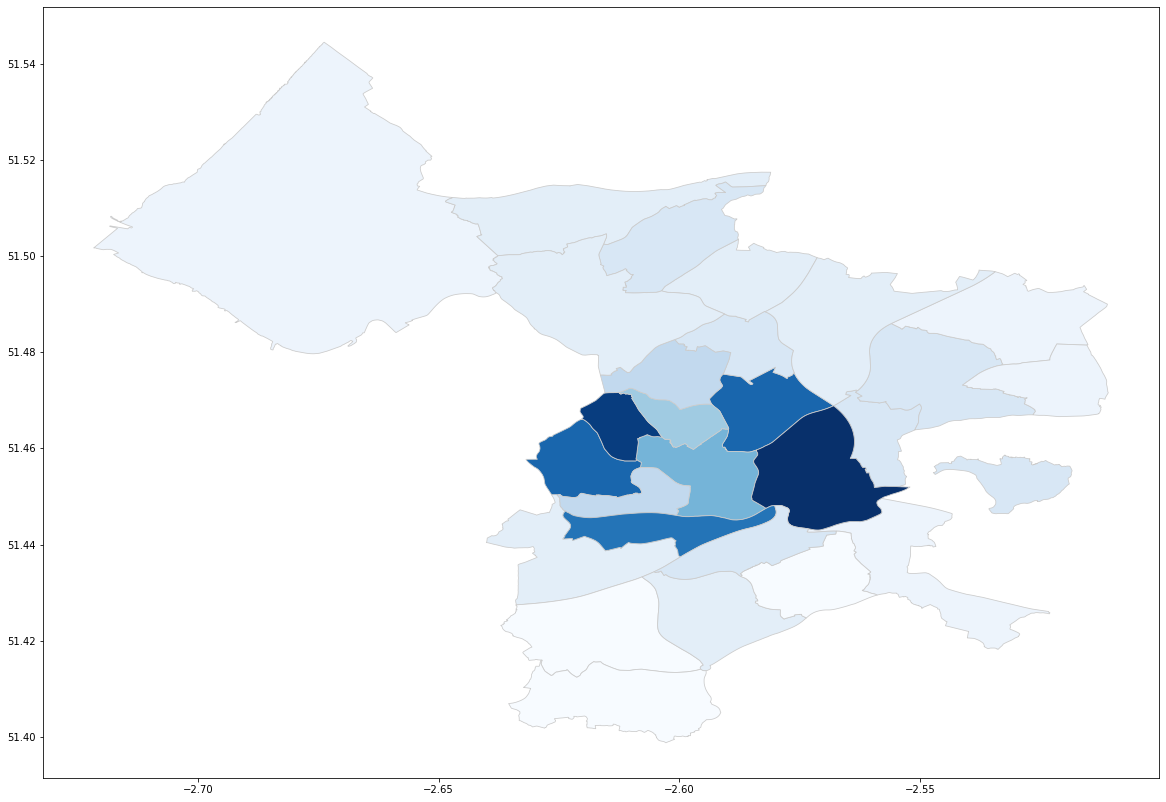

In [21]:
gdf = gpd.GeoDataFrame(df[df["yearmonth"]=="2020-04"], geometry="geometry")
gdf.plot(column="n_reviews", 
        figsize=(20, 20),
        cmap="Blues", 
        linewidth=0.8, 
        edgecolor="0.8")
